In [1]:
import pandas as pd 
import numpy as np
from matplotlib import style
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#tdqm = progress bar
from tqdm import tqdm
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn. model_selection import train_test_split
from sklearn import preprocessing
from sklearn import utils

In [2]:
# Number of rows
nrows = 1000000
# Chunksize = 10000 
chunksize = 10000
# Vitou's path
path = 'C:/Users/Vitou/Downloads/train.csv'
# Muna's path
#path = '/Users/muna/Development/DataScience/new-york-city-taxi-fare-prediction/train.csv'
# Columns to read from the data
# Todo :split date into meaningful data
# cols = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','fare_amount']
cols = ['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','fare_amount']

#list to hold the batch dataframe
df_list = []

for df_chunk in tqdm(pd.read_csv(path,usecols=cols, chunksize=chunksize,nrows=nrows)):
    df_list.append(df_chunk)
    
# Merge all dataframes into one dataframe
data = pd.DataFrame()
data = pd.concat(df_list)
# # Delete the dataframe list to release memory
del df_list, df_chunk

100it [00:01, 56.81it/s]


### Let's take a look at the data

In [3]:
%%time
# data.describe(include='all')

Wall time: 0 ns


### Check for missing values

In [4]:
%%time
# Checking for missing values
data.isnull().sum()

Wall time: 87 ms


fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    10
dropoff_latitude     10
passenger_count       0
dtype: int64

### From our observation, there are some missing values, so we remove them

In [5]:
%%time
data = data.dropna(how = 'any', axis = 'rows')

Wall time: 144 ms


### Let's take a look at the data

In [6]:
data['fare_amount'].describe()

count    999990.000000
mean         11.347953
std           9.821790
min         -44.900000
25%           6.000000
50%           8.500000
75%          12.500000
max         500.000000
Name: fare_amount, dtype: float64

### From the description above, some of the fare_amount have negative values

We are going to remove all negatvie fare_amounts

In [7]:
%%time
data = data[(data['fare_amount'] > 0)]

Wall time: 76 ms


In [8]:
data['fare_amount'].describe()

count    999923.000000
mean         11.348945
std           9.821201
min           0.010000
25%           6.000000
50%           8.500000
75%          12.500000
max         500.000000
Name: fare_amount, dtype: float64

In [9]:
data['fare_amount'].describe()

count    999923.000000
mean         11.348945
std           9.821201
min           0.010000
25%           6.000000
50%           8.500000
75%          12.500000
max         500.000000
Name: fare_amount, dtype: float64

### Let's take a detailed look at the passenger count

In [10]:
data['passenger_count'].describe()

count    999923.000000
mean          1.684955
std           1.323921
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         208.000000
Name: passenger_count, dtype: float64

The highest passenger count per taxi ride is 208, which is not possible. So we remove all passenger_count grater than 6, since 6 is the maximum passenger capacity for Uber/Lyft if the ride is an SUV

In [11]:
data = data[(data['passenger_count'] <= 6)]

In [12]:
data['passenger_count'].describe()

count    999922.000000
mean          1.684748
std           1.307746
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           6.000000
Name: passenger_count, dtype: float64

Now the highest passenger capacity is 6

Next we remove all passenger count that are zero

In [13]:
data = data[(data['passenger_count'] > 0)]

In [14]:
data['passenger_count'].describe()

count    996367.000000
mean          1.690760
std           1.306192
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           6.000000
Name: passenger_count, dtype: float64

Text(0, 0.5, 'Frequency')

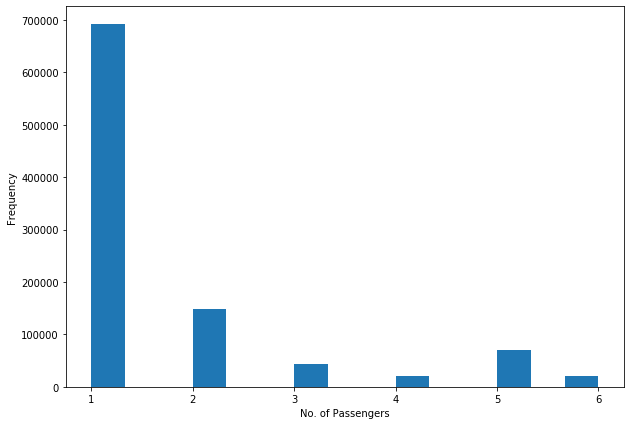

In [15]:
plt.figure(figsize=(10,7)) 
plt.hist(data['passenger_count'], bins=15) 
plt.xlabel('No. of Passengers') 
plt.ylabel('Frequency')

From the graph above we see that single passengers are the most frequent travellers

Text(0, 0.5, 'Fare')

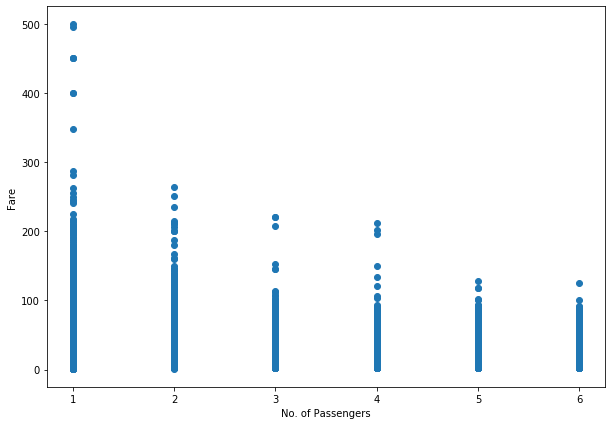

In [16]:
plt.figure(figsize=(10,7)) 
plt.scatter(x=data['passenger_count'], y=data['fare_amount']) 
plt.xlabel('No. of Passengers') 
plt.ylabel('Fare')

Also the highest fare comes from the taxi that carry single passengers

### Looking at the pickup|droppoff latitudes and longitudes

In [17]:
data[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']].describe()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,996367.000000,996367.000000,996367.000000,996367.000000
mean,39.928583,-72.526028,39.919749,-72.527717
std,7.633285,12.065813,8.209446,11.328668
min,-3116.285383,-3377.680935,-3114.338567,-3383.296608
25%,40.734960,-73.992060,40.734043,-73.991383
50%,40.752692,-73.981792,40.753163,-73.980134
75%,40.767152,-73.967092,40.768128,-73.963650
max,2621.628430,2522.271325,1651.553433,45.581619


Looking at the info above, the maximum pickup_latitude/pickup_longtide/droppoff_latitude/dropoff_longitude are over 3000 WITH their respective minimum values are over -3000

Latitudes range from -90 to 90 while longitudes range from -180 to 180, for single degree format. So we remove all values that are not with the latitude and longitude ranges

In [18]:
data = data.drop((data[(data['pickup_latitude'] > 90) | (data['pickup_latitude'] < -90)]).index, axis=0)

In [19]:
data = data.drop((data[(data['pickup_longitude'] > 180) | (data['pickup_longitude'] < -180)]).index, axis=0)

We will do the same for dropoff cordinates

In [20]:
data = data.drop((data[(data['dropoff_latitude'] > 90) | (data['dropoff_latitude'] < -90)]).index, axis=0)

In [21]:
data = data.drop((data[(data['dropoff_longitude'] > 180) | (data['dropoff_longitude'] < -180)]).index, axis=0)

In [22]:
data[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']].describe()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,996327.000000,996327.000000,996327.000000,996327.000000
mean,39.926279,-72.516598,39.925683,-72.515035
std,6.092109,10.396380,6.095567,10.398391
min,-74.016587,-128.175950,-74.035197,-121.391248
25%,40.734960,-73.992059,40.734043,-73.991383
50%,40.752692,-73.981792,40.753163,-73.980134
75%,40.767152,-73.967092,40.768127,-73.963650
max,69.400000,40.850357,81.510177,45.581619


### Feature Engineering

In [23]:
# Given a dataframe, add two new features 'abs_diff_longitude' and
# 'abs_diff_latitude' reprensenting the "Manhattan vector" from
# the pickup location to the dropoff location.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(data)

### In further observation, we have pickup_longitude, puckup_latitiude, dropoff_longitude and dropoff_latitude. We can calculate the distance

In [24]:
# Function that calculates distance between pickup location and dropoff location
def getDistance(lat1,lon1,lat2,lon2):
    r = 6378 # earth's radius
    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2)
    lon2 = np.deg2rad(lon2)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = r*c
    
    return distance

In [25]:
%%time
# Add new cloumn "distance" to the data
data['distance'] = getDistance(data.pickup_latitude, data.pickup_longitude, 
                                      data.dropoff_latitude, data.dropoff_longitude)

Wall time: 139 ms


In [26]:
data['distance'].describe()

count    996327.000000
mean         18.691266
std         358.089205
min           0.000000
25%           1.214427
50%           2.118858
75%           3.888064
max       12608.542887
Name: distance, dtype: float64

We have some distances which are zero. so we remove all

In [27]:
data = data[(data['distance'] > 0)]

In [28]:
data['distance'].describe()

count    967904.000000
mean         19.240145
std         363.294371
min           0.000084
25%           1.281508
50%           2.184615
75%           3.974757
max       12608.542887
Name: distance, dtype: float64

In [29]:
%%time
print(data[::10])

        fare_amount          pickup_datetime  pickup_longitude  \
0              4.50  2009-06-15 17:26:21 UTC        -73.844311   
10             5.30  2012-04-08 07:30:50 UTC        -73.996335   
22             4.50  2009-08-06 18:17:23 UTC        -73.991707   
33             5.70  2011-09-07 14:05:00 UTC        -73.976162   
43            12.10  2009-06-10 21:28:00 UTC        -73.988558   
...             ...                      ...               ...   
999953        14.50  2010-07-14 10:41:03 UTC        -73.977654   
999963         6.50  2009-11-07 02:48:46 UTC        -73.987891   
999973        11.30  2011-05-07 12:53:00 UTC        -73.952537   
999984        44.33  2014-11-02 14:09:53 UTC        -73.872276   
999995         7.00  2014-09-13 21:44:38 UTC        -73.976676   

        pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
0             40.721319         -73.841610         40.712278                1   
10            40.737142         -73.980721   

### Creating new features like year, month, day, hour and dayOfWeek from pickup_datetime

In [30]:
def split_datetime(df):
        df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format="%Y-%m-%d %H:%M:%S UTC")
        df['year'] = df['pickup_datetime'].dt.year
        df['month'] = df['pickup_datetime'].dt.month
        df['day'] = df['pickup_datetime'].dt.day
        df['hour'] = df['pickup_datetime'].dt.hour
        df['dayOfWeek'] = df['pickup_datetime'].dt.dayofweek
        
        return df

In [31]:
%%time
split_datetime(data)

Wall time: 3.46 s


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,distance,year,month,day,hour,dayOfWeek
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041,1.031896,2009,6,15,17,0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701,8.459418,2010,1,5,16,1
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708,1.391052,2011,8,18,0,3
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949,2.802346,2012,4,21,4,5
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754,2.001353,2010,3,9,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,20.0,2014-06-29 22:57:55,-73.872919,40.774106,-73.796524,40.775041,2,0.076395,0.000935,6.440845,2014,6,29,22,6
999995,7.0,2014-09-13 21:44:38,-73.976676,40.785630,-73.959196,40.775114,1,0.017480,0.010516,1.881828,2014,9,13,21,5
999997,10.5,2013-04-26 14:03:00,-73.978423,40.751135,-73.993397,40.762197,5,0.014974,0.011062,1.763677,2013,4,26,14,4
999998,6.9,2011-07-08 00:29:00,-73.980317,40.759482,-73.976832,40.743122,1,0.003485,0.016360,1.844708,2011,7,8,0,4


Text(0, 0.5, 'Fare')

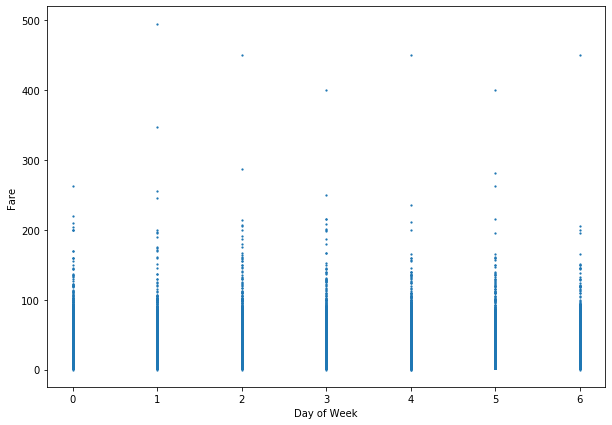

In [32]:
plt.figure(figsize=(10,7)) 
plt.scatter(x=data['dayOfWeek'], y=data['fare_amount'], s=1.5) 
plt.xlabel('Day of Week') 
plt.ylabel('Fare')

The highest fare_amount seen to be on a Friday while the lowest is on s Saturday

Now that we have split pickup_datetime into year, month, day, hour and year

### Let's take a look at hour and dayOfWeek

In [33]:
%%time
data['hour'].describe()

Wall time: 31 ms


count    967904.000000
mean         13.509839
std           6.512759
min           0.000000
25%           9.000000
50%          14.000000
75%          19.000000
max          23.000000
Name: hour, dtype: float64

According to New York Times, rush hours is ususally between 7 to 9AM and from 4 to 6PM. Let's create a new feature from hour

In [34]:
# 1 for rush hour, 0 for not
def rush_hour(hour):
    if hour in range(7, 10) or hour in range(16, 19):
        return 1
    else:
        return 0

In [35]:
%%time
data['rush_hour'] = data['hour'].apply(rush_hour)

Wall time: 781 ms


In [36]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,distance,year,month,day,hour,dayOfWeek,rush_hour
count,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000
mean,11.353128,-73.841819,40.655363,-73.840211,40.654749,1.691507,0.159680,0.091995,19.240145,2011.747038,6.270126,15.694734,13.509839,3.039796,0.279312
std,9.700881,3.495899,2.854369,3.502660,2.862116,1.306600,3.168096,1.689363,363.294371,1.867039,3.436686,8.682551,6.512759,1.949527,0.448661
min,0.010000,-128.175950,-74.016587,-121.391248,-74.035197,1.000000,0.000000,0.000000,0.000084,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992267,40.736487,-73.991563,40.735454,1.000000,0.006332,0.007148,1.281508,2010.000000,3.000000,8.000000,9.000000,1.000000,0.000000
50%,8.500000,-73.982087,40.753366,-73.980587,40.753832,1.000000,0.012894,0.014385,2.184615,2012.000000,6.000000,16.000000,14.000000,3.000000,0.000000
75%,12.500000,-73.968352,40.767546,-73.965342,40.768403,2.000000,0.024223,0.027524,3.974757,2013.000000,9.000000,23.000000,19.000000,5.000000,1.000000
max,495.000000,40.850357,69.400000,45.581619,81.510177,6.000000,119.444978,81.510177,12608.542887,2015.000000,12.000000,31.000000,23.000000,6.000000,1.000000


In [37]:
%%time
data['dayOfWeek'].describe()

Wall time: 25 ms


count    967904.000000
mean          3.039796
std           1.949527
min           0.000000
25%           1.000000
50%           3.000000
75%           5.000000
max           6.000000
Name: dayOfWeek, dtype: float64

We can also create a new feature from daysOfWeek. We can check if it's a weekend or not

In [38]:
# 1 for weekend, 0 for not
def weekend(dayOfWeek):
    if dayOfWeek == 0 or dayOfWeek == 6:
        return 1
    else:
        return 0

In [39]:
%%time
data['weekend'] = data['dayOfWeek'].apply(weekend)

Wall time: 309 ms


In [40]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,distance,year,month,day,hour,dayOfWeek,rush_hour,weekend
count,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000
mean,11.353128,-73.841819,40.655363,-73.840211,40.654749,1.691507,0.159680,0.091995,19.240145,2011.747038,6.270126,15.694734,13.509839,3.039796,0.279312,0.259752
std,9.700881,3.495899,2.854369,3.502660,2.862116,1.306600,3.168096,1.689363,363.294371,1.867039,3.436686,8.682551,6.512759,1.949527,0.448661,0.438499
min,0.010000,-128.175950,-74.016587,-121.391248,-74.035197,1.000000,0.000000,0.000000,0.000084,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992267,40.736487,-73.991563,40.735454,1.000000,0.006332,0.007148,1.281508,2010.000000,3.000000,8.000000,9.000000,1.000000,0.000000,0.000000
50%,8.500000,-73.982087,40.753366,-73.980587,40.753832,1.000000,0.012894,0.014385,2.184615,2012.000000,6.000000,16.000000,14.000000,3.000000,0.000000,0.000000
75%,12.500000,-73.968352,40.767546,-73.965342,40.768403,2.000000,0.024223,0.027524,3.974757,2013.000000,9.000000,23.000000,19.000000,5.000000,1.000000,1.000000
max,495.000000,40.850357,69.400000,45.581619,81.510177,6.000000,119.444978,81.510177,12608.542887,2015.000000,12.000000,31.000000,23.000000,6.000000,1.000000,1.000000


rush_hour and weekend are categorical either 1 or 0, so we can crerate dummy columns from them

In [41]:
data = pd.get_dummies(data, columns=['rush_hour','weekend'])

In [42]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,distance,year,month,day,hour,dayOfWeek,rush_hour_0,rush_hour_1,weekend_0,weekend_1
count,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000,967904.000000
mean,11.353128,-73.841819,40.655363,-73.840211,40.654749,1.691507,0.159680,0.091995,19.240145,2011.747038,6.270126,15.694734,13.509839,3.039796,0.720688,0.279312,0.740248,0.259752
std,9.700881,3.495899,2.854369,3.502660,2.862116,1.306600,3.168096,1.689363,363.294371,1.867039,3.436686,8.682551,6.512759,1.949527,0.448661,0.448661,0.438499,0.438499
min,0.010000,-128.175950,-74.016587,-121.391248,-74.035197,1.000000,0.000000,0.000000,0.000084,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992267,40.736487,-73.991563,40.735454,1.000000,0.006332,0.007148,1.281508,2010.000000,3.000000,8.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,8.500000,-73.982087,40.753366,-73.980587,40.753832,1.000000,0.012894,0.014385,2.184615,2012.000000,6.000000,16.000000,14.000000,3.000000,1.000000,0.000000,1.000000,0.000000
75%,12.500000,-73.968352,40.767546,-73.965342,40.768403,2.000000,0.024223,0.027524,3.974757,2013.000000,9.000000,23.000000,19.000000,5.000000,1.000000,1.000000,1.000000,1.000000
max,495.000000,40.850357,69.400000,45.581619,81.510177,6.000000,119.444978,81.510177,12608.542887,2015.000000,12.000000,31.000000,23.000000,6.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'Fare Amount over Years')

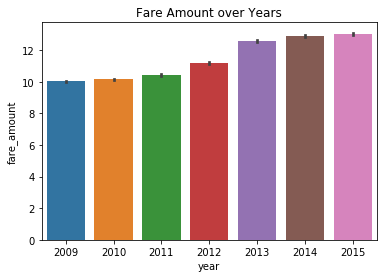

In [43]:
sns.barplot(x=data['year'],y=data["fare_amount"],data=data).set_title("Fare Amount over Years")

From the graph above, it Looks like fares have been incrasing over the years.

In [44]:
%%time
feature_cols = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count',
                'abs_diff_longitude','abs_diff_latitude','distance','year','month','day','hour','dayOfWeek',
                'rush_hour_0','rush_hour_1','weekend_0','weekend_1']

X = data[feature_cols] 
y = data['fare_amount']

Wall time: 40 ms


# Regression Alogorithms

### training of the datatset

In [45]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=2)

Wall time: 236 ms


# Linear Regression

In [46]:
%%time
my_linreg = LinearRegression(n_jobs=-1)
my_linreg.fit(X_train, y_train)
y_prediction_lr = my_linreg.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_prediction_lr)
rmse_lr = np.sqrt(mse)
print(f'Linear Regression:{rmse_lr}')

Linear Regression:9.638608577359905
Wall time: 798 ms


Label Encoding the  y_test and y to prevent continous error

In [47]:
lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)
y_encoded = lab_enc.fit_transform(y)
y_test_encoded = lab_enc.fit_transform(y_test)

#  Logistic Regression

In [48]:
%%time
#max_iter default = 100
my_logreg = LogisticRegression(max_iter=20,solver='sag',multi_class='auto',n_jobs=-1)
my_logreg.fit(X_train, y_train_encoded)
y_prediction_log = my_logreg.predict(X_test)
mse_log = metrics.mean_squared_error(y_test, y_prediction_log)
rmse_log = np.sqrt(mse_log)
print(f'Logistic Regression: {rmse_log}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Logistic Regression: 31.17684522855523
Wall time: 23min 21s


# Random Forest Regression

In [49]:
%%time

my_rfr = RandomForestRegressor(n_estimators = 10, bootstrap=True, random_state=3)
my_rfr.fit(X_train, y_train)
y_prediction_rfr = my_rfr.predict(X_test)
mse_rfr = metrics.mean_squared_error(y_test, y_prediction_rfr)
rmse_rfr = np.sqrt(mse_rfr)
print(f'Random Forest Regressor: {rmse_rfr}')

Random Forest Regressor: 4.008533326281107
Wall time: 1min 45s


# RSME Visualization

Text(0.5, 1.0, 'RMSE Values')

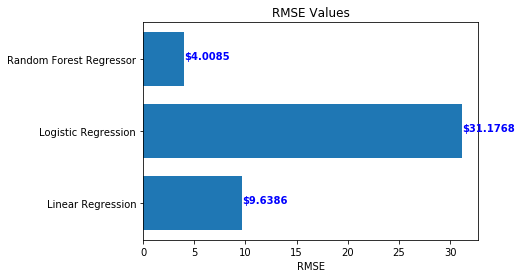

In [50]:
fig, ax = plt.subplots()
y_axis = ('Linear Regression','Logistic Regression','Random Forest Regressor')
y_pos = np.arange(len(y_axis))
width = 0.75 
x_axis = (round(rmse_lr,4),round(rmse_log,4),round(rmse_rfr,4))
ax.barh(y_pos, x_axis, width,align='center')
for i, v in enumerate(x_axis):
    ax.text(v, i, '$'+str(v), color='blue', fontweight='bold')
ax.set_yticks(y_pos)
ax.set_yticklabels(y_axis)
ax.set_xlabel('RMSE')
ax.set_title('RMSE Values')